In [45]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from functools import reduce

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error


import lightgbm as lgbm


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 3

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
targets_lag = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [44]:
#=======================#
def flatten(df, col):
    du = (df.pivot(index="playerId", columns="EvalDate", 
               values=col).add_prefix(f"{col}_").
      rename_axis(None, axis=1).reset_index())
    return du
#============================#
def reducer(left, right):
    return left.merge(right, on="playerId")
#========================

In [6]:
TGTCOLS = ["target1","target2","target3","target4"]
def train_lag(df, lag=1):
    dp = df[["playerId","EvalDate"]+TGTCOLS].copy()
    dp["EvalDate"]  =dp["EvalDate"] + timedelta(days=lag) 
    df = df.merge(dp, on=["playerId", "EvalDate"], suffixes=["",f"_{lag}"], how="left")
    return df
#=================================
def test_lag(sub):
    sub["playerId"] = sub["date_playerId"].apply(lambda s: int(  s.split("_")[1]  ) )
    assert sub.date.nunique() == 1
    dte = sub["date"].unique()[0]
    
    eval_dt = pd.to_datetime(dte, format="%Y%m%d")
    dtes = [eval_dt + timedelta(days=-k) for k in LAGS]
    mp_dtes = {eval_dt + timedelta(days=-k):k for k in LAGS}
    
    sl = LAST.loc[LAST.EvalDate.between(dtes[-1], dtes[0]), ["EvalDate","playerId"]+TGTCOLS].copy()
    sl["EvalDate"] = sl["EvalDate"].map(mp_dtes)
    du = [flatten(sl, col) for col in TGTCOLS]
    du = reduce(reducer, du)
    return du, eval_dt
    #
#===============

In [7]:
targets_lag["EvalDate"] = pd.to_datetime(targets_lag["engagementMetricsDate"])
targets_lag["EvalDate"] = targets_lag["EvalDate"] + timedelta(days=-1)
targets_lag["EvalYear"] = targets_lag["EvalDate"].dt.year

In [8]:
MED_DF = targets_lag.groupby(["playerId","EvalYear"])[TGTCOLS].median().reset_index()
MEDCOLS = ["tgt1_med","tgt2_med", "tgt3_med", "tgt4_med"]
MED_DF.columns = ["playerId","EvalYear"] + MEDCOLS

In [9]:
LAGS = list(range(1,31))
FECOLS = [f"{col}_{lag}" for lag in reversed(LAGS) for col in TGTCOLS]

In [10]:
%%time
for lag in tqdm(LAGS):
    targets_lag = train_lag(targets_lag, lag=lag)
    gc.collect()
#===========
targets_lag = targets_lag.sort_values(by=["playerId", "EvalDate"])
targets_lag
# print(targets.shape)
# targets = targets.dropna()
# print(targets.shape)
# targets = targets.merge(MED_DF, on=["playerId","EvalYear"])


100%|██████████| 30/30 [00:48<00:00,  1.61s/it]


CPU times: user 38.6 s, sys: 12.8 s, total: 51.4 s
Wall time: 51.4 s


,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date,EvalDate,EvalYear,...,target3_28,target4_28,target1_29,target2_29,target3_29,target4_29,target1_30,target2_30,target3_30,target4_30
969,2018-01-02,112526,0.055277,5.496109,0.025839,16.176471,0,20180101,2018-01-01,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3556,2018-01-03,112526,0.060625,3.252914,0.030486,8.541353,1,20180102,2018-01-02,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5737,2018-01-04,112526,0.029341,1.648352,0.032613,10.490112,2,20180103,2018-01-03,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7768,2018-01-05,112526,0.014799,2.665894,0.087422,19.091467,3,20180104,2018-01-04,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8963,2018-01-06,112526,0.083916,1.161002,0.024759,6.643880,4,20180105,2018-01-05,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495980,2021-04-27,685503,0.044617,1.224728,0.009437,0.737463,1211,20210426,2021-04-26,2021,...,2.089865,1.529100,5.333101,6.400267,3.501559,2.694346,2.847250,48.264984,0.547288,6.944986
2497962,2021-04-28,685503,0.019123,1.178880,0.013161,0.790301,1212,20210427,2021-04-27,2021,...,3.089282,0.741931,1.282354,8.539095,2.089865,1.529100,5.333101,6.400267,3.501559,2.694346
2500311,2021-04-29,685503,0.015799,4.323489,0.002350,0.970273,1213,20210428,2021-04-28,2021,...,0.285499,0.693112,0.161984,14.469882,3.089282,0.741931,1.282354,8.539095,2.089865,1.529100
2502400,2021-04-30,685503,0.018770,31.946021,0.305491,5.938273,1214,20210429,2021-04-29,2021,...,0.326401,2.383914,0.017753,6.011942,0.285499,0.693112,0.161984,14.469882,3.089282,0.741931


In [11]:
targets_lag

,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date,EvalDate,EvalYear,...,target3_28,target4_28,target1_29,target2_29,target3_29,target4_29,target1_30,target2_30,target3_30,target4_30
969,2018-01-02,112526,0.055277,5.496109,0.025839,16.176471,0,20180101,2018-01-01,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3556,2018-01-03,112526,0.060625,3.252914,0.030486,8.541353,1,20180102,2018-01-02,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5737,2018-01-04,112526,0.029341,1.648352,0.032613,10.490112,2,20180103,2018-01-03,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7768,2018-01-05,112526,0.014799,2.665894,0.087422,19.091467,3,20180104,2018-01-04,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8963,2018-01-06,112526,0.083916,1.161002,0.024759,6.643880,4,20180105,2018-01-05,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495980,2021-04-27,685503,0.044617,1.224728,0.009437,0.737463,1211,20210426,2021-04-26,2021,...,2.089865,1.529100,5.333101,6.400267,3.501559,2.694346,2.847250,48.264984,0.547288,6.944986
2497962,2021-04-28,685503,0.019123,1.178880,0.013161,0.790301,1212,20210427,2021-04-27,2021,...,3.089282,0.741931,1.282354,8.539095,2.089865,1.529100,5.333101,6.400267,3.501559,2.694346
2500311,2021-04-29,685503,0.015799,4.323489,0.002350,0.970273,1213,20210428,2021-04-28,2021,...,0.285499,0.693112,0.161984,14.469882,3.089282,0.741931,1.282354,8.539095,2.089865,1.529100
2502400,2021-04-30,685503,0.018770,31.946021,0.305491,5.938273,1214,20210429,2021-04-29,2021,...,0.326401,2.383914,0.017753,6.011942,0.285499,0.693112,0.161984,14.469882,3.089282,0.741931


In [12]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

feature_cols3 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

In [13]:
players

,playerId,playerName,DOB,mlbDebutDate,birthCity,birthStateProvince,birthCountry,heightInches,weight,primaryPositionCode,primaryPositionName,playerForTestSetAndFuturePreds
0,665482,Gilberto Celestino,1999-02-13,2021-06-02,Santo Domingo,NaN,Dominican Republic,72,170,8,Outfielder,False
1,593590,Webster Rivas,1990-08-08,2021-05-28,Nagua,NaN,Dominican Republic,73,219,3,First Base,True
2,661269,Vladimir Gutierrez,1995-09-18,2021-05-28,Havana,NaN,Cuba,73,190,1,Pitcher,True
3,669212,Eli Morgan,1996-05-13,2021-05-28,Rancho Palos Verdes,CA,USA,70,190,1,Pitcher,True
4,666201,Alek Manoah,1998-01-09,2021-05-27,Homestead,FL,USA,78,260,1,Pitcher,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2056,672695,Geraldo Perdomo,1999-10-22,NaN,Santo Domingo,NaN,Dominican Republic,74,203,6,Shortstop,True
2057,672911,Jesus Cruz,1995-04-15,NaN,Salinas de Hidalgo,San Luis Potosi,Mexico,73,230,1,Pitcher,False
2058,676103,Damon Jones,1994-09-30,NaN,Twin Falls,ID,USA,77,233,1,Pitcher,True
2059,676755,Isaac Mattson,1995-07-14,NaN,Erie,PA,USA,74,205,1,Pitcher,True


In [14]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [15]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')

# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [16]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month

In [17]:
targets_lag = targets_lag.sort_index()
lag_columns = list(targets_lag.columns)[10:]

In [18]:
train = pd.concat([train, targets_lag[lag_columns]], axis=1).dropna(subset=lag_columns).reset_index(drop=True)
train

,playerId,target1,target2,target3,target4,date,primaryPositionName,birthCity,DOY,mlbDebutYear,...,target3_28,target4_28,target1_29,target2_29,target3_29,target4_29,target1_30,target2_30,target3_30,target4_30
0,571841,0.000533,1.422107,0.000755,0.745192,20180131,Second Base,Dallas,1988,2016.0,...,0.000000,0.773861,0.000000,0.569260,0.000000,0.902256,0.001675,0.632296,0.000738,0.931373
1,519203,0.207223,15.319974,2.302627,7.283654,20180131,First Base,Parkland,1989,2011.0,...,0.814430,15.004299,3.849689,5.177555,0.270257,8.360902,3.609756,9.143969,0.253219,13.627451
2,456068,0.001955,5.559147,0.005286,0.793269,20180131,Pitcher,Gudalajara,1984,2012.0,...,0.001812,1.031814,0.005867,1.545134,0.000824,0.781955,0.003908,1.507782,0.000000,1.274510
3,571901,0.000000,2.197802,0.020391,0.312500,20180131,Pitcher,Raceland,1987,2012.0,...,0.000000,0.386930,0.000000,1.111412,0.001648,0.240602,0.000000,1.264591,0.000000,0.784314
4,502188,0.001066,6.464124,0.007552,3.629808,20180131,Pitcher,Merrillville,1985,2008.0,...,0.005436,4.299226,0.001956,5.855245,0.004120,3.308271,0.004467,4.474708,0.002215,7.254902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444341,451661,0.000000,0.013314,0.000000,0.625925,20210430,Pitcher,Athens,1985,2013.0,...,0.000000,0.951826,0.000000,0.010985,0.000000,0.621891,0.000000,0.041178,0.000000,0.301523
2444342,519301,0.000131,0.003329,0.000000,0.216229,20210430,Pitcher,Minneapolis,1988,2015.0,...,0.000000,0.145688,0.001324,0.021970,0.000000,0.082919,0.000795,0.006863,0.000398,0.046991
2444343,527055,0.000000,0.019971,0.000000,0.273131,20210430,Pitcher,Yaguate,1990,2011.0,...,0.004574,0.369075,0.000000,0.065909,0.000000,0.248756,0.000088,0.123533,0.000000,0.195794
2444344,543484,0.000131,0.056586,0.000000,1.024240,20210430,Outfielder,Lafayette,1989,2015.0,...,0.000000,1.019814,0.000265,0.131817,0.001640,1.202322,0.000442,0.398051,0.000000,0.657869


In [19]:
train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]

_index = (train['date'].astype(int) < 20210401)
x_train = train_X.loc[_index].reset_index(drop=True)
y_train = train_y.loc[_index].reset_index(drop=True)
x_valid = train_X.loc[~_index].reset_index(drop=True)
y_valid = train_y.loc[~_index].reset_index(drop=True)

In [20]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    oof_pred = np.clip(oof_pred, 0, 100)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


# training lightgbm
params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}

oof1, model1, score1 = fit_lgbm(
    x_train[feature_cols1 + lag_columns], y_train['target1'],
    x_valid[feature_cols1 + lag_columns], y_valid['target1'],
    params
)
oof2, model2, score2 = fit_lgbm(
    x_train[feature_cols2 + lag_columns], y_train['target2'],
    x_valid[feature_cols2 + lag_columns], y_valid['target2'],
    params
)
oof3, model3, score3 = fit_lgbm(
    x_train[feature_cols3 + lag_columns], y_train['target3'],
    x_valid[feature_cols3 + lag_columns], y_valid['target3'],
    params
)
oof4, model4, score4 = fit_lgbm(
    x_train[feature_cols4 + lag_columns], y_train['target4'],
    x_valid[feature_cols4 + lag_columns], y_valid['target4'],
    params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.66651
[200]	valid_0's l1: 0.664732
[300]	valid_0's l1: 0.664617
Early stopping, best iteration is:
[249]	valid_0's l1: 0.664617
mae: 0.6646104245124371
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.24751
[200]	valid_0's l1: 1.24024
[300]	valid_0's l1: 1.23884
[400]	valid_0's l1: 1.23098
Early stopping, best iteration is:
[370]	valid_0's l1: 1.23062
mae: 1.2304973798798067
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.507932
Early stopping, best iteration is:
[47]	valid_0's l1: 0.507177
mae: 0.5071764270575972
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.01606
Early stopping, best iteration is:
[55]	valid_0's l1: 1.01228
mae: 1.0122815360086213
score: 0.8536414418646155


In [21]:
score: 0.9954547214078484


In [22]:
oof_df = pd.DataFrame()
oof_df['date_playerId'] = train['date'][~_index].reset_index(drop=True).astype(str) + '_' + x_valid['label_playerId'].values.astype(str)
oof_df['target1'] = oof1
oof_df['target2'] = oof2
oof_df['target3'] = oof3
oof_df['target4'] = oof4
oof_df

,date_playerId,target1,target2,target3,target4
0,20210401_1845,3.869329,16.014081,0.114428,10.347284
1,20210401_1770,0.000000,0.237986,0.015515,0.100774
2,20210401_1663,0.001487,0.101898,0.009659,3.657807
3,20210401_1756,0.003339,4.265375,0.012392,0.831777
4,20210401_1704,0.073733,1.655712,0.370587,0.627145
...,...,...,...,...,...
61825,20210430_159,0.000008,0.045785,0.000012,0.773745
61826,20210430_555,0.000127,0.005048,0.000012,0.129829
61827,20210430_437,0.000061,0.020810,0.000291,0.290542
61828,20210430_1611,0.000166,0.048198,0.000061,0.614304


In [23]:
oof_df.to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv', index=False)

In [24]:
models = [model1, model2, model3, model4]
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

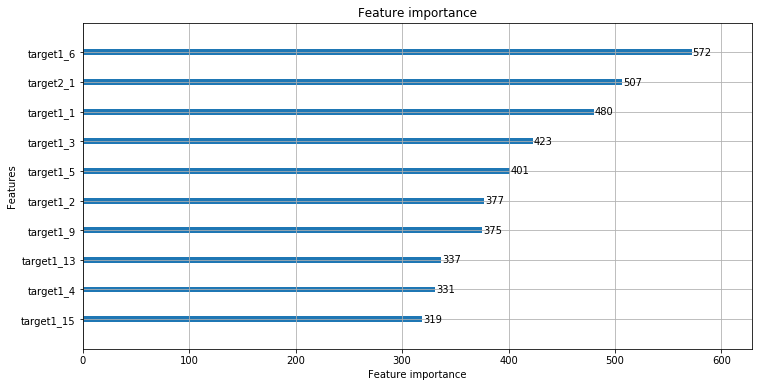

In [25]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

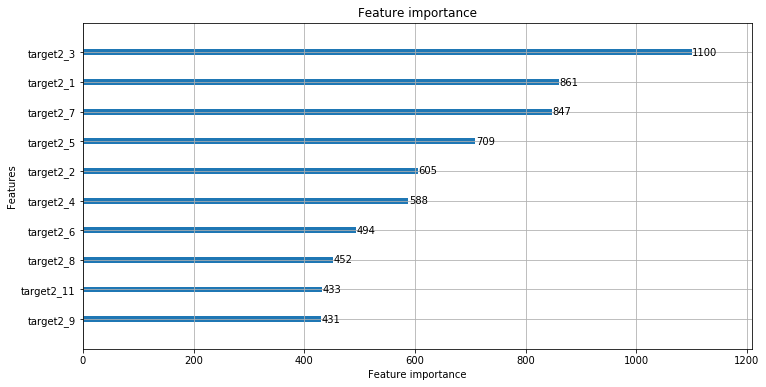

In [26]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

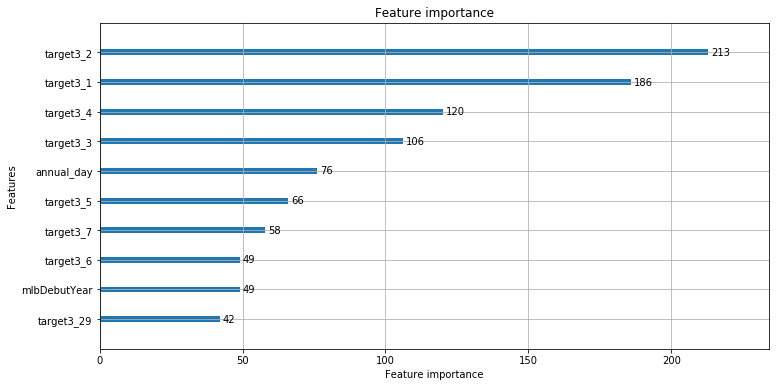

In [27]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

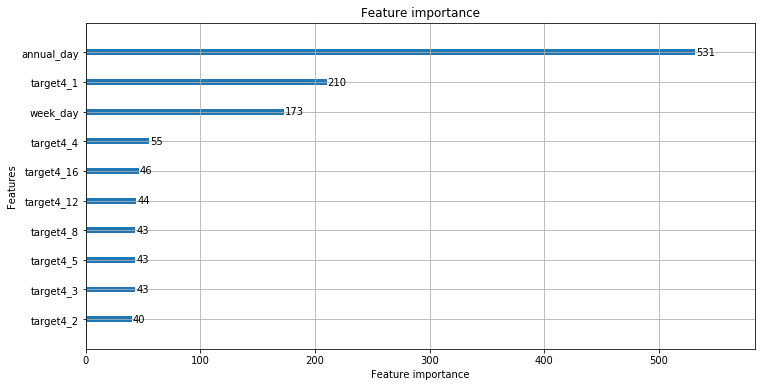

In [28]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [33]:
bound_dt = pd.to_datetime("2021-01-01")
LAST = targets_lag.loc[pd.to_datetime(targets_lag.engagementMetricsDate, format="%Y-%m-%d")>bound_dt].copy()

In [64]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [65]:
sample_prediction_df = sample_prediction_df.reset_index()


In [66]:
sub = sample_prediction_df

In [70]:
sub

,date,date_playerId,target1,target2,target3,target4,playerId
0,20210426,20210427_656669,0,0,0,0,656669
1,20210426,20210427_543475,0,0,0,0,543475
2,20210426,20210427_592866,0,0,0,0,592866
3,20210426,20210427_452678,0,0,0,0,452678
4,20210426,20210427_570257,0,0,0,0,570257
...,...,...,...,...,...,...,...
1182,20210426,20210427_593590,0,0,0,0,593590
1183,20210426,20210427_642180,0,0,0,0,642180
1184,20210426,20210427_663399,0,0,0,0,663399
1185,20210426,20210427_664199,0,0,0,0,664199


In [68]:
sub["playerId"] = sub["date_playerId"].apply(lambda s: int(  s.split("_")[1]  ) )
assert sub.date.nunique() == 1
dte = sub["date"].unique()[0]

In [82]:
eval_dt + timedelta(days=30)

Timestamp('2021-05-31 00:00:00')

In [90]:
eval_dt = pd.to_datetime(dte, format="%Y%m%d")
eval_dt += timedelta(days=60)
dtes = [eval_dt + timedelta(days=-k) for k in LAGS]
mp_dtes = {eval_dt + timedelta(days=-k):k for k in LAGS}

In [91]:
sl = LAST.loc[LAST.EvalDate.between(dtes[-1], dtes[0]), ["EvalDate","playerId"]+TGTCOLS].copy()

In [92]:
sl

,EvalDate,playerId,target1,target2,target3,target4


In [ ]:



sl["EvalDate"] = sl["EvalDate"].map(mp_dtes)
du = [flatten(sl, col) for col in TGTCOLS]
du = reduce(reducer, du)
return du, eval_dt

In [46]:
sub_fe, eval_dt = test_lag(sample_prediction_df)

In [48]:
sub_fe

,playerId,target1_1,target1_2,target1_3,target1_4,target1_5,target1_6,target1_7,target1_8,target1_9,...,target4_21,target4_22,target4_23,target4_24,target4_25,target4_26,target4_27,target4_28,target4_29,target4_30
0,112526,0.014222,0.004605,0.002811,0.006305,0.009606,0.005212,0.006032,0.005231,0.002419,...,8.206560,4.772106,3.089358,12.451437,17.900083,7.025101,5.267714,8.004369,11.815371,21.498244
1,134181,0.005878,0.002187,0.002715,0.003869,0.004269,0.002535,0.004208,0.003138,0.002016,...,3.773473,1.730699,0.978466,4.050117,4.736733,2.635392,2.343267,4.618505,6.868375,12.641436
2,279571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000141,0.000000,0.000000,0.000134,...,0.041597,0.039462,0.014181,0.067988,0.124378,0.043075,0.080376,0.156031,0.176678,0.273117
3,282332,0.013653,0.008288,0.002133,0.004442,0.005203,0.004366,0.005331,0.005928,0.006316,...,4.052769,2.928658,1.618621,7.400932,7.151741,3.951130,6.318783,6.444063,9.143110,14.592275
4,400085,0.040769,0.102108,0.012797,0.041555,0.017211,0.018452,0.019639,0.023363,0.018410,...,12.235560,7.213124,5.481839,22.066822,26.451078,8.720680,8.501298,22.000312,29.483216,47.171284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,681911,0.000000,0.000000,0.000000,0.000143,0.000133,0.000141,0.000000,0.000349,0.001075,...,0.112907,0.073287,0.048619,0.203963,0.279851,0.137056,0.123655,0.577313,0.242933,0.663285
2057,683232,0.000190,0.000000,0.000000,0.000000,0.000000,0.000141,0.000140,0.000000,0.000000,...,0.029712,0.036643,0.018232,0.067988,0.031095,0.074402,0.030914,0.109221,0.044170,0.429185
2058,683734,0.075659,0.044320,0.070675,0.321261,0.258031,0.653691,0.117274,0.106007,0.246323,...,3.583314,2.480480,0.838685,6.060606,13.246269,3.058308,3.548906,7.676705,6.448763,13.499805
2059,685493,0.000379,0.000115,0.000000,0.000716,0.000267,0.000000,0.000281,0.000174,0.000941,...,0.606133,0.307241,0.178271,1.029526,0.798093,0.477738,0.346235,0.608519,1.413428,3.511510


In [49]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')

test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [52]:
test_X = pd.merge(test_X, sub_fe, how='left', on='playerId')

In [53]:
test_X

,playerId,primaryPositionName,birthCity,DOY,mlbDebutYear,DebutAge,heightInches,weight,teamId,status,...,target4_21,target4_22,target4_23,target4_24,target4_25,target4_26,target4_27,target4_28,target4_29,target4_30
0,656669,Outfielder,Visalia,1993,2017.0,24.0,73,195,114.0,Active,...,0.356549,0.642670,0.548994,0.456488,0.414594,1.104280,0.296773,0.374473,0.552120,0.936403
1,543475,Pitcher,Hartsville,1990,2011.0,21.0,77,230,140.0,Active,...,0.356549,0.321335,0.850840,0.699301,0.445688,0.254533,0.173117,0.374473,1.325088,0.702302
2,592866,Pitcher,San Diego,1992,2016.0,24.0,75,235,112.0,Active,...,20.537200,38.379795,0.702956,1.476301,0.953566,1.076869,0.772845,1.139023,4.615724,4.838080
3,452678,Third Base,Puerto La Cruz,1985,2007.0,22.0,72,235,109.0,Active,...,2.662230,0.639851,1.035188,2.690365,5.254975,3.066139,0.809942,3.026993,4.284452,7.218104
4,570257,Pitcher,Santo Domingo,1991,2016.0,25.0,73,200,140.0,Active,...,0.083195,0.042281,0.018232,0.174825,0.145108,0.082234,0.074193,0.156031,0.242933,0.429185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,593590,First Base,Nagua,1990,2021.0,31.0,73,219,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1183,642180,Shortstop,Murrieta,1994,2017.0,23.0,73,188,147.0,Reassigned to Minors,...,1.194438,0.287510,0.168142,1.660839,0.756633,0.834084,0.432793,0.858168,2.385159,4.642996
1184,663399,Pitcher,Houston,1994,2020.0,26.0,75,180,142.0,Reassigned to Minors,...,0.065367,0.047918,0.024310,0.233100,0.269486,0.039159,0.049462,0.468092,0.596290,0.897386
1185,664199,Pitcher,Ashburn,1993,2019.0,26.0,76,217,109.0,Active,...,0.344664,0.076106,0.062800,0.339938,0.953566,0.203626,0.105107,0.265252,0.265018,0.507218


In [58]:
# predict
pred1 = model1.predict(test_X[feature_cols1 + lag_columns])
pred2 = model2.predict(test_X[feature_cols2 + lag_columns])
pred3 = model3.predict(test_X[feature_cols3 + lag_columns])
pred4 = model4.predict(test_X[feature_cols4 + lag_columns])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']
del sample_prediction_df['date']

In [59]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,1.089141e+01,5.935786,1.887653,2.405942
1,20210427_543475,9.376606e-03,0.907329,0.007883,0.650705
2,20210427_592866,2.858552e-02,3.960914,0.009003,1.358640
3,20210427_452678,2.029732e-02,1.382449,0.007917,1.601011
4,20210427_570257,6.624952e-04,0.203986,0.003932,0.100352
...,...,...,...,...,...
1182,20210427_593590,4.478426e-15,0.007662,0.000012,0.000672
1183,20210427_642180,1.074629e-03,0.319180,0.000085,0.391131
1184,20210427_663399,3.160613e-04,0.069477,0.000053,0.145151
1185,20210427_664199,1.243282e-03,0.146417,0.000590,0.152803
